In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
from torchvision import models, transforms
import cv2
import torch
from matplotlib.gridspec import GridSpec
from matplotlib import pyplot as plt
from matplotlib import patches

In [3]:
from zse.models.adain_module import AdaINLitModule2D
from zse.models.components.adain_net import AdaINNet
from zse.models.components.adain_unet import AdaINUNet
from zse.models.components.unet import UNet

In [4]:
def plot_qualitative(img, path):
    img = img.squeeze(0).permute(1,2,0).detach().cpu().numpy()
    lx, ly = (125, 80)
    c1_x, c1_y = (25, 150)
    c2_x, c2_y = (340, 100)
    cell1 = patches.Rectangle((c1_x, c1_y), lx, ly, linewidth=1, edgecolor='b', facecolor='none')
    cell2 = patches.Rectangle((c2_x, c2_y), lx, ly, linewidth=1, edgecolor='r', facecolor='none')

    plt.figure(dpi=200)
    gs1 = GridSpec(4, 4, wspace=0.05, hspace=0.05, left=0, right=0.43)
    ax1 = plt.subplot(gs1[:-1, :])
    ax2 = plt.subplot(gs1[-1, :-2])
    ax3 = plt.subplot(gs1[-1, -2:])
    ax1.imshow(img)
    ax1.add_patch(cell1)
    ax1.add_patch(cell2)
    ax1.axis("off")
    ax2.imshow(img[c1_y:c1_y+ly+1, c1_x:c1_x+lx+1])
    ax2.add_patch(patches.Rectangle((0, 0), lx, ly, linewidth=1, edgecolor='b', facecolor='none'))
    ax2.axis("off")
    ax3.imshow(img[c2_y:c2_y+ly+1, c2_x:c2_x+lx+1])
    ax3.add_patch(patches.Rectangle((0, 0), lx, ly, linewidth=1, edgecolor='r', facecolor='none'))
    ax3.axis("off")
    plt.savefig(path, bbox_inches='tight', pad_inches=0)
    plt.show()

In [12]:
home = "/p/fastdata/bigbrains/personal/crijnen1"
data_root = f"{home}/data"
zse_path = f"{home}/Z-Stack-Enhancement"
exp_path = f"{zse_path}/logs/experiments/runs/leishmania"
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [6]:
path = f"{data_root}/COMI/Leishmania/Leishmania_blurred_test/173_0.jpg"
dest = f"{zse_path}/notebooks/leishmania/qualitative"

In [11]:
vgg19 = models.vgg19(pretrained=True)
norm = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
adain_unet = AdaINUNet(vgg19, norm, out_channels=3)
adain = AdaINNet(vgg19, norm, out_channels=3)
unet = UNet(vgg19, norm, in_channels=3, out_channels=3)

In [7]:
to_tensor = transforms.ToTensor()
blurry_img = cv2.imread(path)
blurry_img = cv2.resize(blurry_img, dsize=(512, 512))
blurry_img = to_tensor(blurry_img).unsqueeze(0)
sharp_img = cv2.imread(path.replace("blurred", "clear"))
sharp_img = cv2.resize(sharp_img, dsize=(512, 512))
sharp_img = to_tensor(sharp_img).unsqueeze(0)

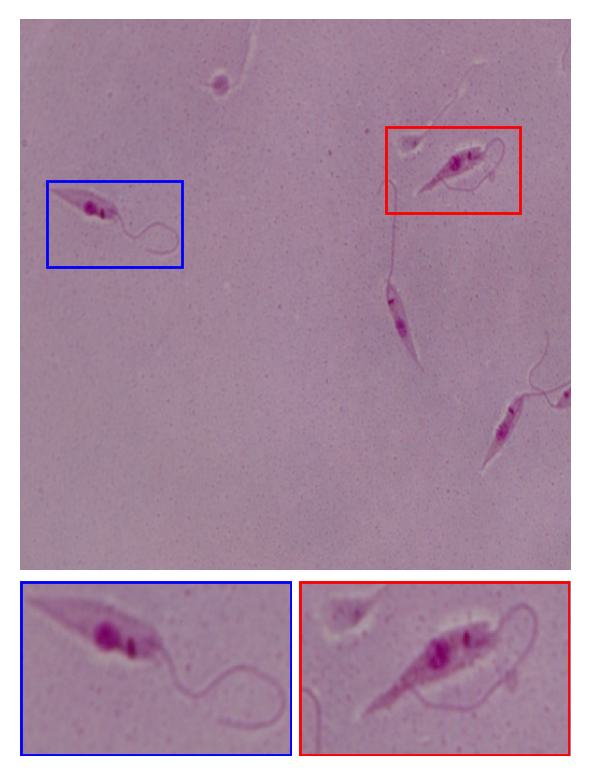

In [28]:
plot_qualitative(sharp_img, f"{dest}/sharp.png")

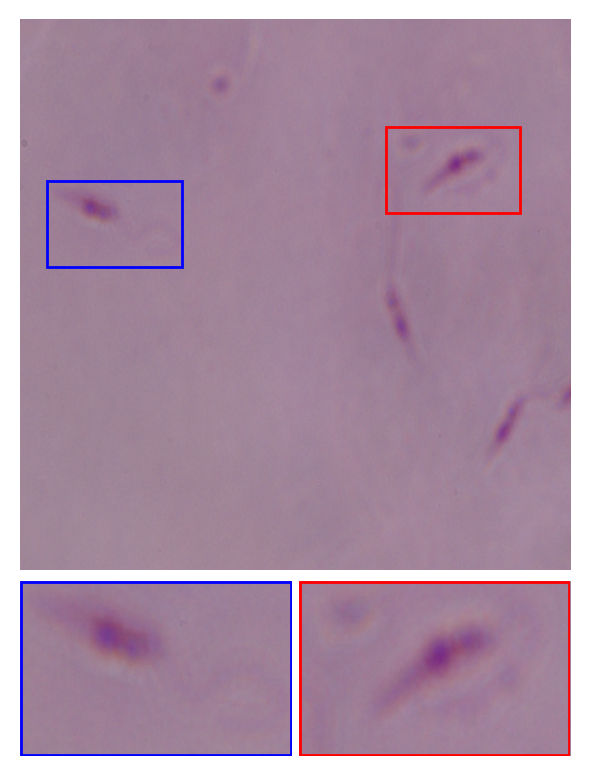

In [29]:
plot_qualitative(blurry_img, f"{dest}/blurry.png")

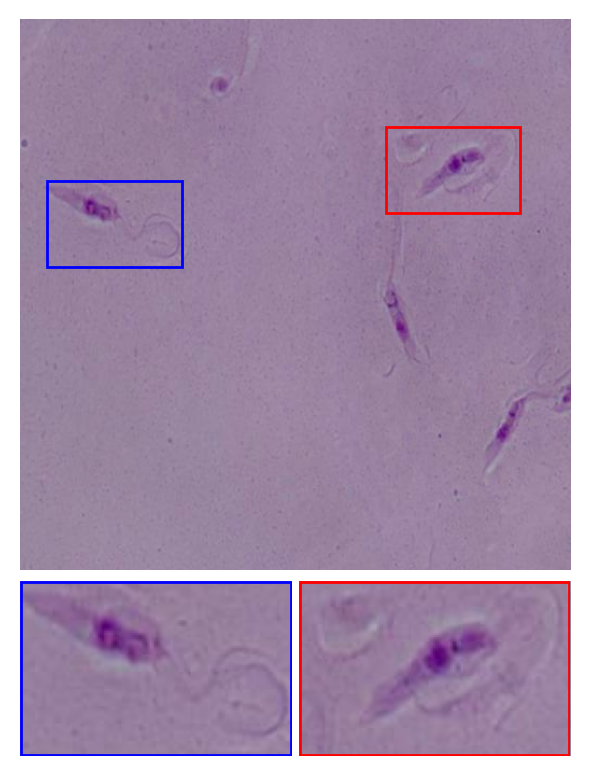

In [30]:
gatys = cv2.imread(f"{data_root}/COMI/Leishmania/predictions/gatys_style/173_0.jpg")
gatys = to_tensor(gatys).unsqueeze(0)
plot_qualitative(gatys, f"{dest}/gatys.png")

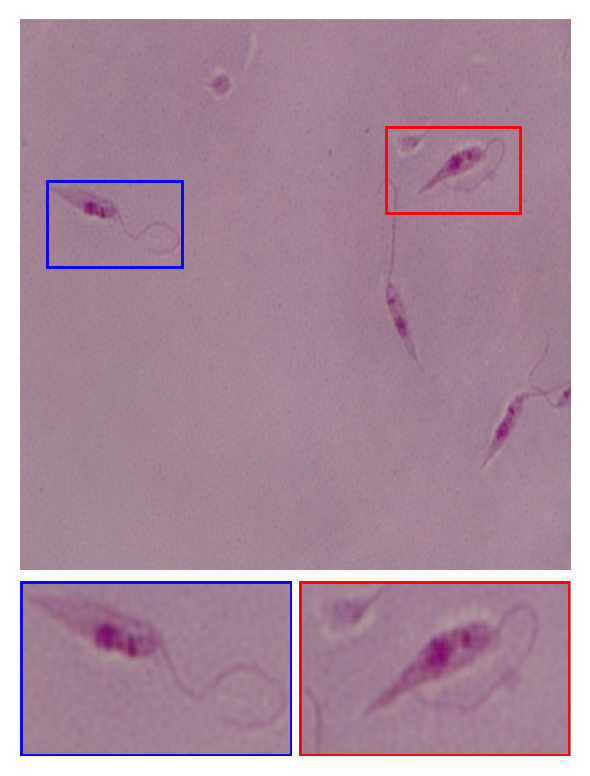

In [32]:
comi = cv2.imread(f"{data_root}/COMI/Leishmania/predictions/comi_gan/173_0.jpg")
comi = to_tensor(comi).unsqueeze(0)
plot_qualitative(comi, f"{dest}/comi.png")

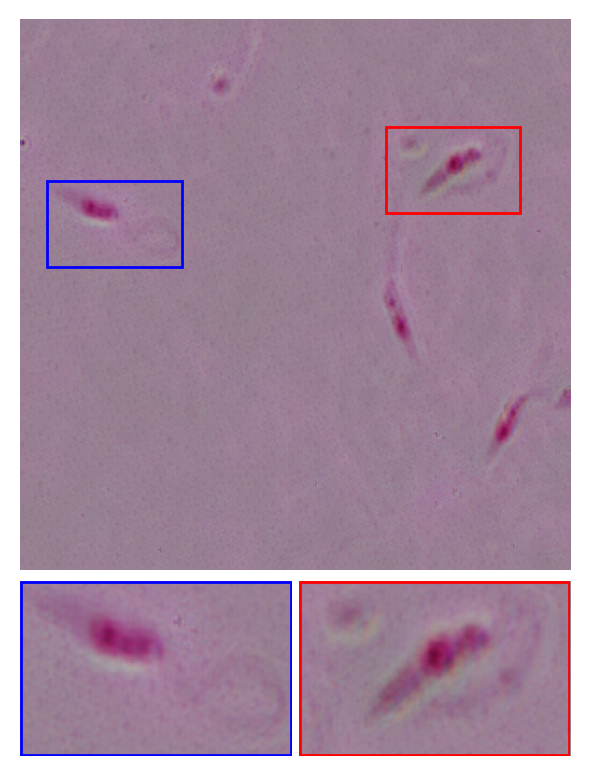

In [21]:
ckpt_path = f"{exp_path}/adain/gram_loss/lr:0.0001-style_weight:100.0-weight_decay:0-lr_decay:1/2022-11-26_02-29-24/checkpoints/epoch_088.ckpt"
module = AdaINLitModule2D.load_from_checkpoint(ckpt_path, net=adain, strict=False).to(device)
module.freeze()
module.eval()
out = module({"content": blurry_img.to(device), "style": sharp_img.to(device)})
plot_qualitative(out, f"{dest}/adain_gram.png")

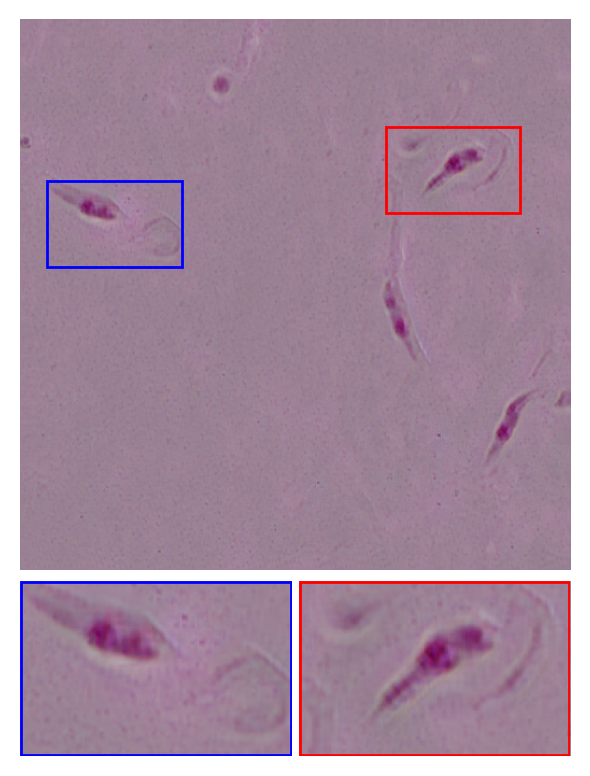

In [22]:
ckpt_path = f"{exp_path}/adain/adain_loss/lr:0.0005-style_weight:1.0-weight_decay:0-lr_decay:1/2022-11-26_01-28-34/checkpoints/epoch_079.ckpt"
module = AdaINLitModule2D.load_from_checkpoint(ckpt_path, net=adain, strict=False).to(device)
module.freeze()
module.eval()
out = module({"content": blurry_img.to(device), "style": sharp_img.to(device)})
plot_qualitative(out, f"{dest}/adain_adain.png")

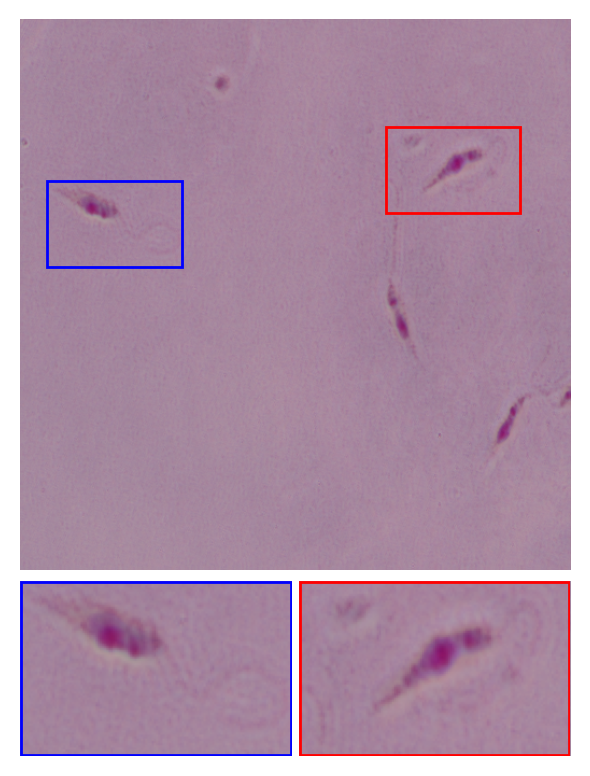

In [23]:
ckpt_path = f"{exp_path}/u17/gram_loss/lr:0.001-style_weight:10000.0-weight_decay:0-lr_decay:1/2022-11-27_16-35-35/checkpoints/epoch_036.ckpt"
module = AdaINLitModule2D.load_from_checkpoint(ckpt_path, net=unet, strict=False).to(device)
module.freeze()
module.eval()
out = module({"content": blurry_img.to(device), "style": sharp_img.to(device)})
plot_qualitative(out, f"{dest}/u17_gram.png")

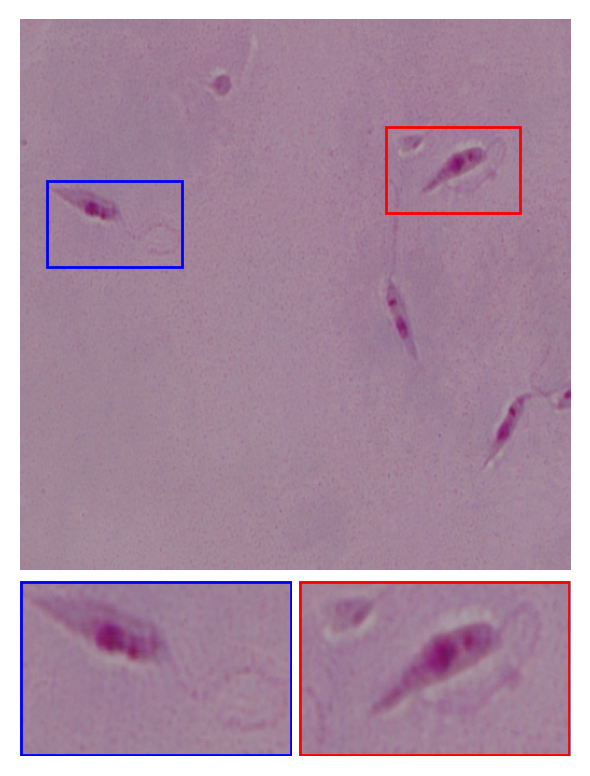

In [24]:
ckpt_path = f"{exp_path}/u17/adain_loss/lr:0.0001-style_weight:100.0-weight_decay:0-lr_decay:1/2022-11-27_15-42-58/checkpoints/epoch_092.ckpt"
module = AdaINLitModule2D.load_from_checkpoint(ckpt_path, net=unet, strict=False).to(device)
module.freeze()
module.eval()
out = module({"content": blurry_img.to(device), "style": sharp_img.to(device)})
plot_qualitative(out, f"{dest}/u17_adain.png")

/p/fastdata/bigbrains/personal/crijnen1/anaconda3/envs/dl/lib/python3.9/site-packages/pytorch_lightning/core/saving.py:263: UserWarning: Found keys that are in the model state dict but not in the checkpoint: ['val_fid.inception.Conv2d_1a_3x3.conv.weight', 'val_fid.inception.Conv2d_1a_3x3.bn.weight', 'val_fid.inception.Conv2d_1a_3x3.bn.bias', 'val_fid.inception.Conv2d_1a_3x3.bn.running_mean', 'val_fid.inception.Conv2d_1a_3x3.bn.running_var', 'val_fid.inception.Conv2d_2a_3x3.conv.weight', 'val_fid.inception.Conv2d_2a_3x3.bn.weight', 'val_fid.inception.Conv2d_2a_3x3.bn.bias', 'val_fid.inception.Conv2d_2a_3x3.bn.running_mean', 'val_fid.inception.Conv2d_2a_3x3.bn.running_var', 'val_fid.inception.Conv2d_2b_3x3.conv.weight', 'val_fid.inception.Conv2d_2b_3x3.bn.weight', 'val_fid.inception.Conv2d_2b_3x3.bn.bias', 'val_fid.inception.Conv2d_2b_3x3.bn.running_mean', 'val_fid.inception.Conv2d_2b_3x3.bn.running_var', 'val_fid.inception.Conv2d_3b_1x1.conv.weight', 'val_fid.inception.Conv2d_3b_1x1.bn.

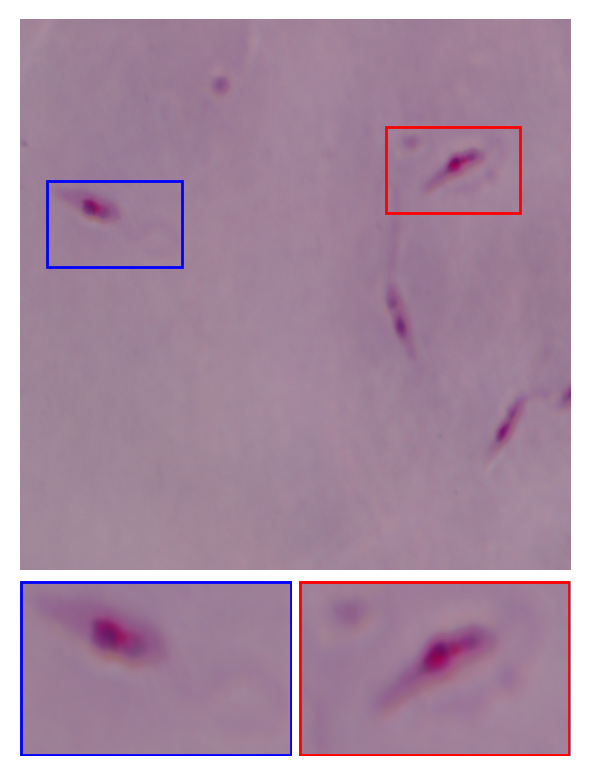

In [25]:
ckpt_path = f"{zse_path}/models/leishmania_best.ckpt"
module = AdaINLitModule2D.load_from_checkpoint(ckpt_path, net=adain_unet, strict=False).to(device)
module.freeze()
module.eval()
out = module({"content": blurry_img.to(device), "style": sharp_img.to(device)})
plot_qualitative(out, f"{dest}/adain_unet_random.png")

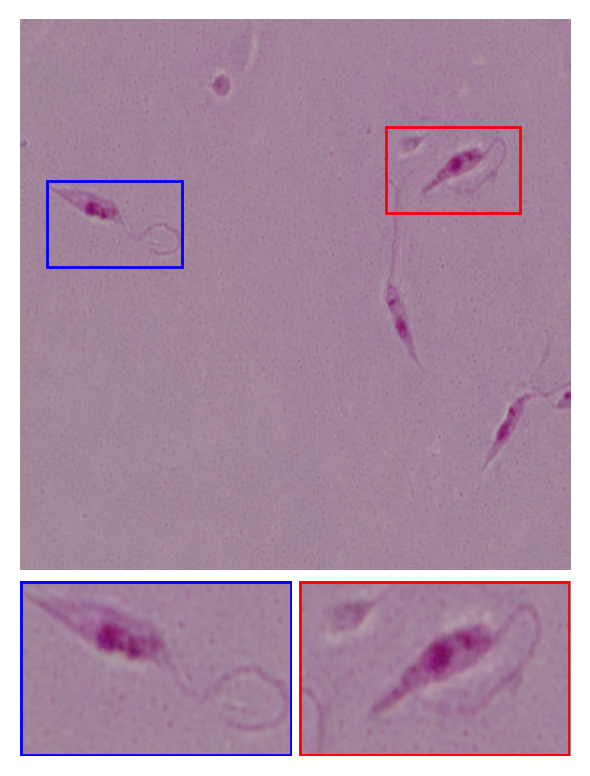

In [26]:
ckpt_path = f"{exp_path}/unet/gram_loss/lr:0.001-style_weight:1000000.0-weight_decay:0-lr_decay:1/2022-11-25_13-11-21/checkpoints/epoch_082.ckpt"
module = AdaINLitModule2D.load_from_checkpoint(ckpt_path, net=adain_unet, strict=False).to(device)
module.freeze()
module.eval()
out = module({"content": blurry_img.to(device), "style": sharp_img.to(device)})
plot_qualitative(out, f"{dest}/adain_unet_gram.png")

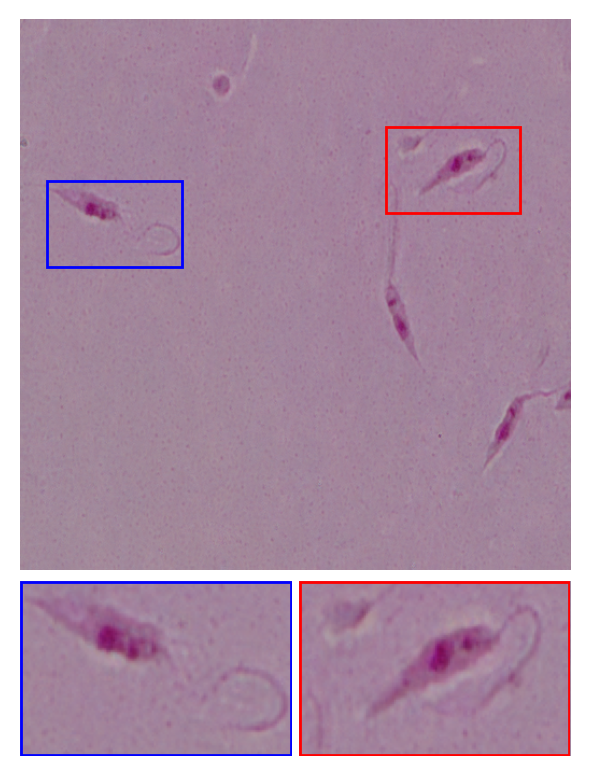

In [27]:
ckpt_path = f"{exp_path}/unet/adain_loss/lr:0.001-style_weight:100.0-weight_decay:0-lr_decay:1/2022-11-25_16-43-30/checkpoints/epoch_098.ckpt"
module = AdaINLitModule2D.load_from_checkpoint(ckpt_path, net=adain_unet, strict=False).to(device)
module.freeze()
module.eval()
out = module({"content": blurry_img.to(device), "style": sharp_img.to(device)})
plot_qualitative(out, f"{dest}/adain_unet_adain.png")